In [28]:
import nibabel as nib
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import plotly.graph_objs as go

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [35]:
import nibabel as nib
import numpy as np

def check_nii_image_type(nii_path):
    # Load the NIfTI image using nibabel
    nii_image = nib.load(nii_path)
    
    # Get the image data as a numpy array
    image_data = nii_image.get_fdata()
    
    # Check the unique values in the image
    unique_values = np.unique(image_data)
    
    # Check if the image is binary
    if len(unique_values) == 2:
        if set(unique_values) == {0, 1} or set(unique_values) == {0, 255}:
            return "Binary Image"
    
    # If more than two unique values are present, it's grayscale
    if len(unique_values) > 2:
        return "Grayscale Image"
    
    return "Unknown Image Type"

# Example usage:
nii_path = '/home/uca/Downloads/Image-Segmentation/PKG - UPENN-GBM-NIfTI/UPENN-GBM/NIfTI-files/images_segm/UPENN-GBM-00002_11_segm.nii.gz'
image_type = check_nii_image_type(nii_path)
print("The NIfTI image is:", image_type)


The NIfTI image is: Grayscale Image


In [37]:
# Load the segmentation file
segmentation_data = nib.load(nii_path).get_fdata()

# Ensure segmentation data is converted to integer type for unique value inspection
segmentation_data = segmentation_data.astype(np.int32)

# Get unique values in the segmentation data to verify binary segmentation
unique_values = np.unique(segmentation_data)
print("Unique values in the segmentation file:", unique_values)


Unique values in the segmentation file: [0 1 2 4]


In [29]:
# Set up paths
base_folder = "PKG - UPENN-GBM-NIfTI"
nifti_folder = os.path.join(base_folder, 'UPENN-GBM', 'NIfTI-files')

# Function to load all NIfTI files from the directory
def load_nifti_files(directory):
    nifti_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                file_path = os.path.join(root, file)
                nifti_files.append(file_path)
    return nifti_files

# Get all NIfTI files
nifti_files = load_nifti_files(nifti_folder)
print(f"Found {len(nifti_files)} NIfTI files.")

Found 10646 NIfTI files.


Image shape: (240, 240, 155)
Resolution: [1. 1. 1.]


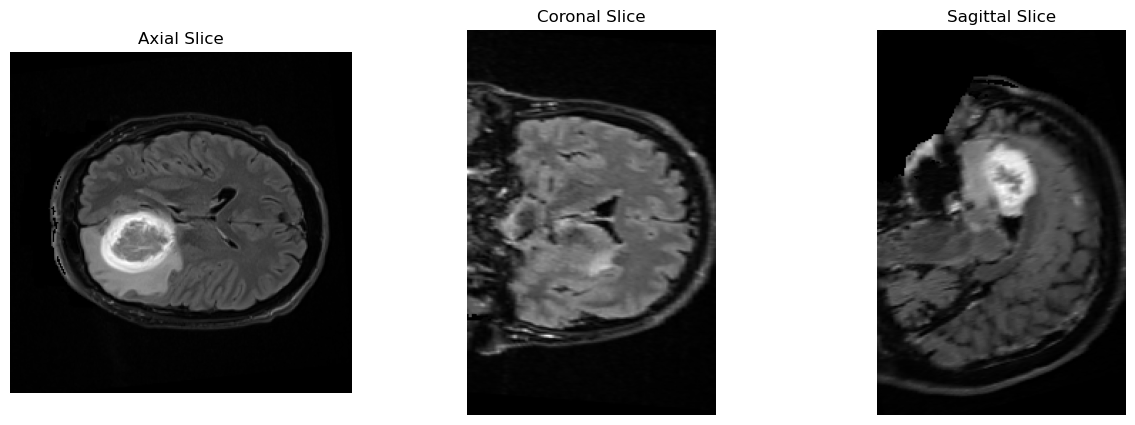

In [30]:
# Function to load a NIfTI image and return the image data and header
def load_nifti_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    header = img.header
    return data, header

# Function to display three slices (axial, coronal, sagittal) in one row
def display_slices(image_data):
    # Calculate the middle indices for each plane
    axial_slice = image_data.shape[2] // 2    # Middle slice in Z (Axial view)
    coronal_slice = image_data.shape[1] // 2  # Middle slice in Y (Coronal view)
    sagittal_slice = image_data.shape[0] // 2 # Middle slice in X (Sagittal view)
    
    # Create subplots for 3 slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display axial slice (XY plane)
    axes[0].imshow(image_data[:, :, axial_slice], cmap="gray")
    axes[0].set_title('Axial Slice')
    axes[0].axis('off')
    
    # Display coronal slice (XZ plane)
    axes[1].imshow(image_data[:, coronal_slice, :], cmap="gray")
    axes[1].set_title('Coronal Slice')
    axes[1].axis('off')
    
    # Display sagittal slice (YZ plane)
    axes[2].imshow(image_data[sagittal_slice, :, :], cmap="gray")
    axes[2].set_title('Sagittal Slice')
    axes[2].axis('off')
    
    # Show the plot
    plt.show()

# Load and display three slices from the first NIfTI file
example_file = nifti_files[1]
image_data, header = load_nifti_image(example_file)
print(f"Image shape: {image_data.shape}")
print(f"Resolution: {header['pixdim'][1:4]}")

# Display three slices (axial, coronal, sagittal) in a row
display_slices(image_data)


Found 611 segmentation masks.


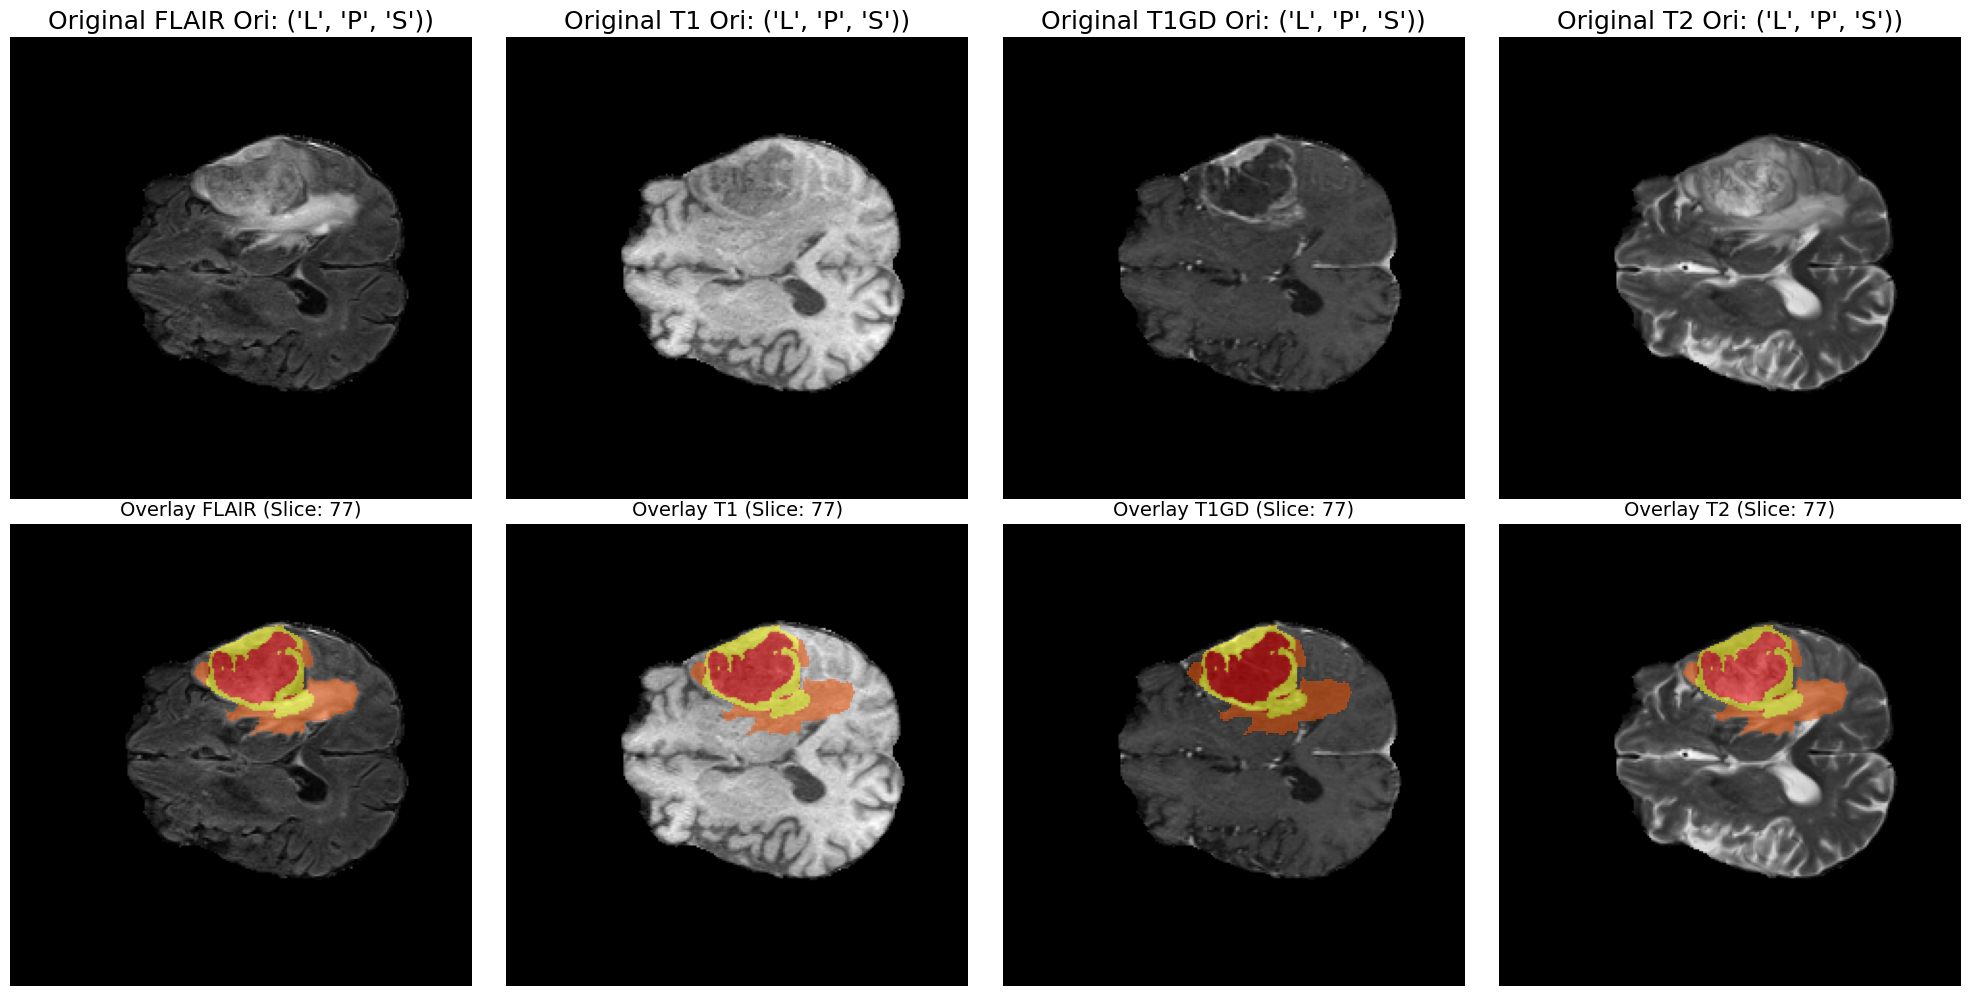

In [34]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Function to load a NIfTI image and get additional information
def load_nifti_image_with_info(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    header = img.header
    shape = data.shape
    resolution = header['pixdim'][1:4]  # Voxel resolution
    affine = img.affine  # Affine matrix to get orientation information
    orientation = nib.aff2axcodes(affine)  # Get the orientation
    return data, shape, resolution, orientation  # Return orientation along with other info

# Function to display four structural images, their tumor segmentation, and the overlay
def display_structural_and_overlay(structural_images, segmentation_data, slice_index, labels, info):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

    for i, (image_data, label) in enumerate(zip(structural_images, labels)):
        shape, resolution, orientation = info[i]
        
        # Top row: Original structural MRI image
        axes[0, i].imshow(image_data[:, :, slice_index], cmap="gray")
        axes[0, i].set_title(f"Original {label} Ori: {orientation})", fontsize=18)
        axes[0, i].axis('off')

        # Bottom row: Structural MRI image with tumor overlay
        axes[1, i].imshow(image_data[:, :, slice_index], cmap="gray")
        tumor_overlay = np.ma.masked_where(segmentation_data[:, :, slice_index] == 0, segmentation_data[:, :, slice_index])
        axes[1, i].imshow(tumor_overlay, cmap="autumn", alpha=0.5)  # Tumor overlay with transparency
        axes[1, i].set_title(f"Overlay {label} (Slice: {slice_index})", fontsize=14)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Function to recursively find NIfTI files in a directory
def find_nifti_files(directory):
    nifti_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

# Function to find the structural images for a given case
def find_structural_images_with_info(case_dir):
    modalities = ['FLAIR', 'T1', 'T1GD', 'T2']
    structural_images = []
    labels = []
    image_info = []
    
    for modality in modalities:
        modality_file = os.path.join(case_dir, f"{os.path.basename(case_dir)}_{modality}.nii.gz")
        if os.path.exists(modality_file):
            image_data, shape, resolution, orientation = load_nifti_image_with_info(modality_file)
            structural_images.append(image_data)
            labels.append(modality)
            image_info.append((shape, resolution, orientation))  # Store shape, resolution, and orientation info
        else:
            print(f"Warning: {modality} image not found in {case_dir}")
    
    return structural_images, labels, image_info

# Main script to execute the functions
def main():
    # Directories for structural images and segmentation masks
    base_dir = "PKG - UPENN-GBM-NIfTI/UPENN-GBM/NIfTI-files"
    structural_dir = os.path.join(base_dir, "images_structural")
    segm_dir = os.path.join(base_dir, "automated_segm")

    # Load the segmentation files
    segmentation_files = find_nifti_files(segm_dir)
    print(f"Found {len(segmentation_files)} segmentation masks.")

    # Iterate over the segmentation masks
    for segmentation_file in segmentation_files:
        # Extract the case ID from the segmentation file
        base_segmentation_name = os.path.basename(segmentation_file).split('_')[0:2]
        case_id = '_'.join(base_segmentation_name)
        
        # Find the corresponding structural folder
        case_structural_dir = os.path.join(structural_dir, case_id)
        
        if os.path.exists(case_structural_dir):
            # Load the structural images (FLAIR, T1, T1GD, T2) and their info (shape, resolution)
            structural_images, labels, image_info = find_structural_images_with_info(case_structural_dir)
            
            # If we have 4 modalities, proceed
            if len(structural_images) == 4:
                # Load the segmentation mask
                segmentation_data, _, _, _ = load_nifti_image_with_info(segmentation_file)
                
                # Choose a slice index (middle slice for visualization)
                slice_index = segmentation_data.shape[2] // 2
                
                # Display the four structural images, their overlays, and additional info
                display_structural_and_overlay(structural_images, segmentation_data, slice_index, labels, image_info)
                
                # Stop after visualizing the first case (you can remove this to visualize all cases)
                break
        else:
            print(f"Structural folder for {case_id} not found.")

# Run the main function
if __name__ == "__main__":
    main()


Found 611 segmentation masks.
Slice 0: Foreground Area = 0
Slice 1: Foreground Area = 0
Slice 2: Foreground Area = 0
Slice 3: Foreground Area = 0
Slice 4: Foreground Area = 0
Slice 5: Foreground Area = 0
Slice 6: Foreground Area = 0
Slice 7: Foreground Area = 0
Slice 8: Foreground Area = 0
Slice 9: Foreground Area = 0
Slice 10: Foreground Area = 0
Slice 11: Foreground Area = 0
Slice 12: Foreground Area = 0
Slice 13: Foreground Area = 0
Slice 14: Foreground Area = 0
Slice 15: Foreground Area = 0
Slice 16: Foreground Area = 0
Slice 17: Foreground Area = 0
Slice 18: Foreground Area = 0
Slice 19: Foreground Area = 0
Slice 20: Foreground Area = 0
Slice 21: Foreground Area = 0
Slice 22: Foreground Area = 0
Slice 23: Foreground Area = 0
Slice 24: Foreground Area = 0
Slice 25: Foreground Area = 0
Slice 26: Foreground Area = 0
Slice 27: Foreground Area = 0
Slice 28: Foreground Area = 0
Slice 29: Foreground Area = 0
Slice 30: Foreground Area = 0
Slice 31: Foreground Area = 0
Slice 32: Foreground

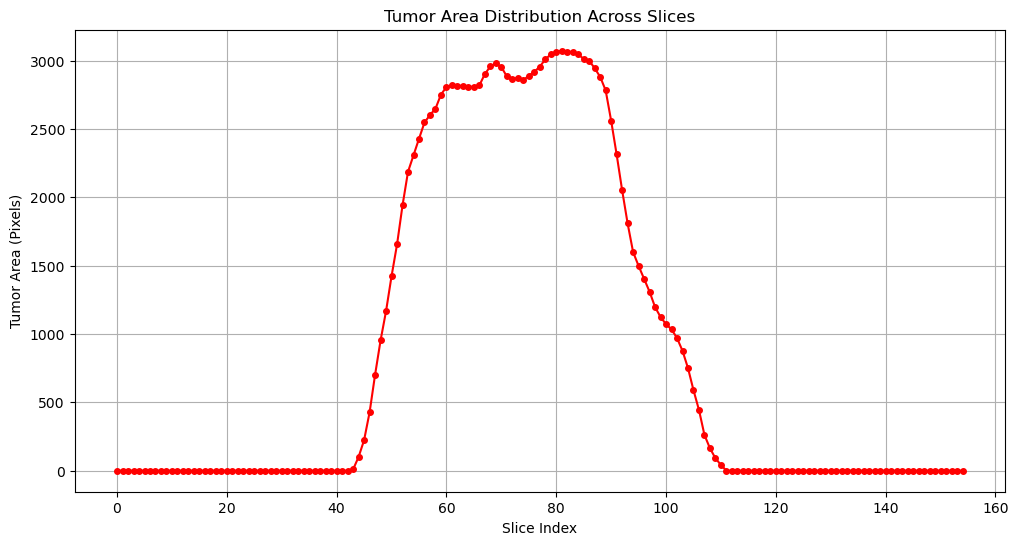

In [18]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Function to load a NIfTI image
def load_nifti_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

# Function to calculate foreground areas for each slice
def calculate_foreground_areas(segmentation_data):
    foreground_areas = []
    
    # Loop through each slice and calculate the tumor area
    for slice_index in range(segmentation_data.shape[2]):
        binary_mask = (segmentation_data[:, :, slice_index] > 0).astype(np.uint8)
        foreground_area = np.sum(binary_mask)

        # Debugging output
        print(f"Slice {slice_index}: Foreground Area = {foreground_area}")

        # Only add non-zero areas
        if foreground_area > 0:
            foreground_areas.append(foreground_area)
        else:
            foreground_areas.append(0)  # Append zero for slices without tumor

    return foreground_areas

# Function to visualize the distribution of tumor areas across all slices
def visualize_area_distribution(areas):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(areas)), areas, marker='o', color='red', markersize=4)
    plt.title('Tumor Area Distribution Across Slices')
    plt.xlabel('Slice Index')
    plt.ylabel('Tumor Area (Pixels)')
    plt.grid()
    plt.show()

# Function to recursively find NIfTI files in a directory
def find_nifti_files(directory):
    nifti_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

# Function to find the structural images for a given case
def find_structural_images(case_dir):
    modalities = ['FLAIR', 'T1', 'T1GD', 'T2']
    structural_images = []
    labels = []
    
    for modality in modalities:
        modality_file = os.path.join(case_dir, f"{os.path.basename(case_dir)}_{modality}.nii.gz")
        if os.path.exists(modality_file):
            structural_images.append(load_nifti_image(modality_file))
            labels.append(modality)
        else:
            print(f"Warning: {modality} image not found in {case_dir}")
    
    return structural_images, labels

# Directories for structural images and segmentation masks
base_dir = "PKG - UPENN-GBM-NIfTI/UPENN-GBM/NIfTI-files"
structural_dir = os.path.join(base_dir, "images_structural")
segm_dir = os.path.join(base_dir, "automated_segm")

# Load the segmentation files
segmentation_files = find_nifti_files(segm_dir)
print(f"Found {len(segmentation_files)} segmentation masks.")

# Iterate over the segmentation masks
for segmentation_file in segmentation_files:
    # Extract the case ID from the segmentation file
    base_segmentation_name = os.path.basename(segmentation_file).split('_')[0:2]
    case_id = '_'.join(base_segmentation_name)
    
    # Find the corresponding structural folder
    case_structural_dir = os.path.join(structural_dir, case_id)
    
    if os.path.exists(case_structural_dir):
        # Load the structural images (FLAIR, T1, T1GD, T2)
        structural_images, labels = find_structural_images(case_structural_dir)
        
        # If we have 4 modalities, proceed
        if len(structural_images) == 4:
            # Load the segmentation mask
            segmentation_data = load_nifti_image(segmentation_file)

            # Calculate the foreground areas for each slice
            foreground_areas = calculate_foreground_areas(segmentation_data)
            print(f"Foreground Areas (Tumor) per Slice: {foreground_areas}")

            # Visualize the distribution of tumor areas across all slices
            visualize_area_distribution(foreground_areas)
            
            # Stop after visualizing the first case (you can remove this to visualize all cases)
            break
    else:
        print(f"Structural folder for {case_id} not found.")


Found 611 segmentation masks.
Slice 0: Foreground Area = 0, Background Area = 57600.0
Slice 1: Foreground Area = 0, Background Area = 57600.0
Slice 2: Foreground Area = 0, Background Area = 57600.0
Slice 3: Foreground Area = 0, Background Area = 57600.0
Slice 4: Foreground Area = 0, Background Area = 57600.0
Slice 5: Foreground Area = 0, Background Area = 57600.0
Slice 6: Foreground Area = 0, Background Area = 57600.0
Slice 7: Foreground Area = 0, Background Area = 57600.0
Slice 8: Foreground Area = 0, Background Area = 57600.0
Slice 9: Foreground Area = 0, Background Area = 57600.0
Slice 10: Foreground Area = 0, Background Area = 57600.0
Slice 11: Foreground Area = 0, Background Area = 57600.0
Slice 12: Foreground Area = 0, Background Area = 57600.0
Slice 13: Foreground Area = 0, Background Area = 57600.0
Slice 14: Foreground Area = 0, Background Area = 57600.0
Slice 15: Foreground Area = 0, Background Area = 57600.0
Slice 16: Foreground Area = 0, Background Area = 57600.0
Slice 17: F

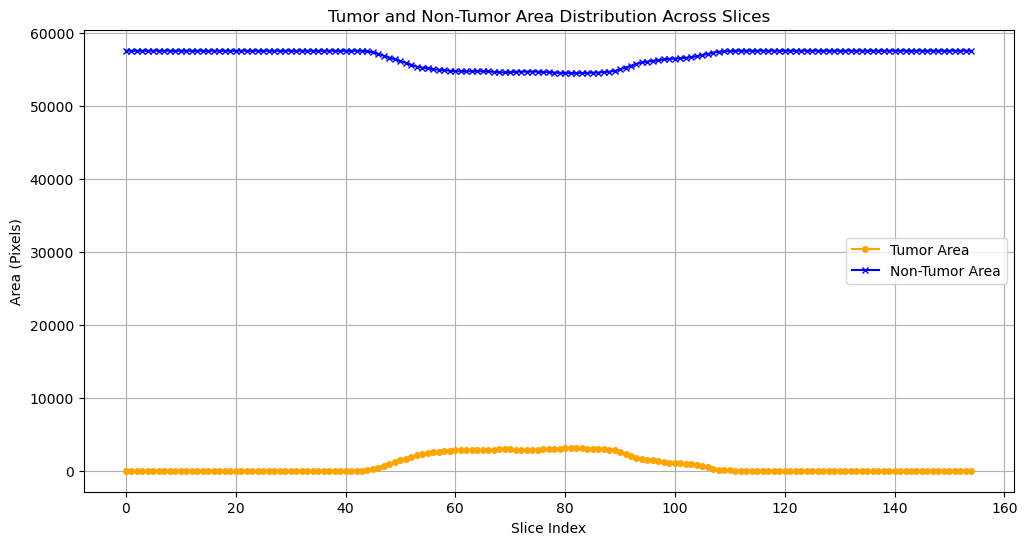

In [19]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Function to load a NIfTI image
def load_nifti_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

# Function to calculate foreground (tumor) and background areas for each slice
def calculate_areas(segmentation_data):
    foreground_areas = []
    background_areas = []
    
    total_pixels = segmentation_data.shape[0] * segmentation_data.shape[1]

    # Loop through each slice and calculate the tumor and background areas
    for slice_index in range(segmentation_data.shape[2]):
        binary_mask = (segmentation_data[:, :, slice_index] > 0).astype(np.uint8)
        foreground_area = np.sum(binary_mask)
        background_area = total_pixels - foreground_area

        # Debugging output
        print(f"Slice {slice_index}: Foreground Area = {foreground_area}, Background Area = {background_area}")

        foreground_areas.append(foreground_area)
        background_areas.append(background_area)

    return foreground_areas, background_areas

# Function to visualize the distribution of tumor and non-tumor areas across all slices
def visualize_area_distribution(foreground_areas, background_areas):
    plt.figure(figsize=(12, 6))

    # Plotting tumor areas
    plt.plot(range(len(foreground_areas)), foreground_areas, marker='o', color='orange', markersize=4, label='Tumor Area')

    # Plotting non-tumor areas
    plt.plot(range(len(background_areas)), background_areas, marker='x', color='blue', markersize=4, label='Non-Tumor Area')

    plt.title('Tumor and Non-Tumor Area Distribution Across Slices')
    plt.xlabel('Slice Index')
    plt.ylabel('Area (Pixels)')
    plt.legend()
    plt.grid()
    plt.show()

# Function to recursively find NIfTI files in a directory
def find_nifti_files(directory):
    nifti_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

# Function to find the structural images for a given case
def find_structural_images(case_dir):
    modalities = ['FLAIR', 'T1', 'T1GD', 'T2']
    structural_images = []
    labels = []
    
    for modality in modalities:
        modality_file = os.path.join(case_dir, f"{os.path.basename(case_dir)}_{modality}.nii.gz")
        if os.path.exists(modality_file):
            structural_images.append(load_nifti_image(modality_file))
            labels.append(modality)
        else:
            print(f"Warning: {modality} image not found in {case_dir}")
    
    return structural_images, labels

# Directories for structural images and segmentation masks
base_dir = "PKG - UPENN-GBM-NIfTI/UPENN-GBM/NIfTI-files"
structural_dir = os.path.join(base_dir, "images_structural")
segm_dir = os.path.join(base_dir, "automated_segm")

# Load the segmentation files
segmentation_files = find_nifti_files(segm_dir)
print(f"Found {len(segmentation_files)} segmentation masks.")

# Iterate over the segmentation masks
for segmentation_file in segmentation_files:
    # Extract the case ID from the segmentation file
    base_segmentation_name = os.path.basename(segmentation_file).split('_')[0:2]
    case_id = '_'.join(base_segmentation_name)
    
    # Find the corresponding structural folder
    case_structural_dir = os.path.join(structural_dir, case_id)
    
    if os.path.exists(case_structural_dir):
        # Load the structural images (FLAIR, T1, T1GD, T2)
        structural_images, labels = find_structural_images(case_structural_dir)
        
        # If we have 4 modalities, proceed
        if len(structural_images) == 4:
            # Load the segmentation mask
            segmentation_data = load_nifti_image(segmentation_file)

            # Calculate the foreground and background areas for each slice
            foreground_areas, background_areas = calculate_areas(segmentation_data)
            print(f"Foreground Areas (Tumor) per Slice: {foreground_areas}")
            print(f"Background Areas per Slice: {background_areas}")

            # Visualize the distribution of tumor and non-tumor areas across all slices
            visualize_area_distribution(foreground_areas, background_areas)
            
            # Stop after visualizing the first case (you can remove this to visualize all cases)
            break
    else:
        print(f"Structural folder for {case_id} not found.")


Found 611 segmentation masks.
Slice 0: Foreground Area = 0
Slice 1: Foreground Area = 0
Slice 2: Foreground Area = 0
Slice 3: Foreground Area = 0
Slice 4: Foreground Area = 0
Slice 5: Foreground Area = 0
Slice 6: Foreground Area = 0
Slice 7: Foreground Area = 0
Slice 8: Foreground Area = 0
Slice 9: Foreground Area = 0
Slice 10: Foreground Area = 0
Slice 11: Foreground Area = 0
Slice 12: Foreground Area = 0
Slice 13: Foreground Area = 0
Slice 14: Foreground Area = 0
Slice 15: Foreground Area = 0
Slice 16: Foreground Area = 0
Slice 17: Foreground Area = 0
Slice 18: Foreground Area = 0
Slice 19: Foreground Area = 0
Slice 20: Foreground Area = 0
Slice 21: Foreground Area = 0
Slice 22: Foreground Area = 0
Slice 23: Foreground Area = 0
Slice 24: Foreground Area = 0
Slice 25: Foreground Area = 0
Slice 26: Foreground Area = 0
Slice 27: Foreground Area = 0
Slice 28: Foreground Area = 0
Slice 29: Foreground Area = 0
Slice 30: Foreground Area = 0
Slice 31: Foreground Area = 0
Slice 32: Foreground

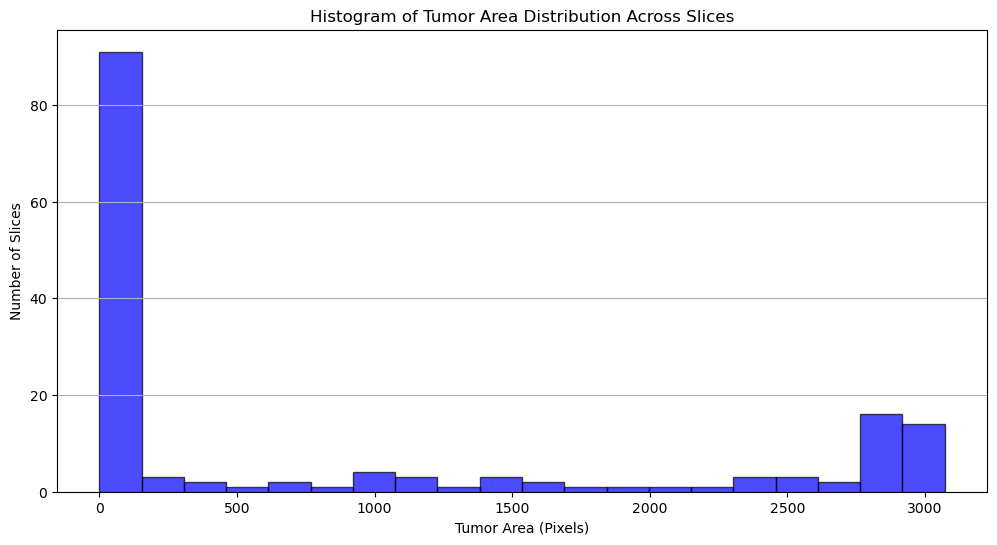

Number of Non-Zero Areas: 68/155
Skewness: -0.6235256974040294
Kurtosis: -1.130900265670659
Ratio of Non-Zero Areas: 0.44


In [23]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Function to load a NIfTI image
def load_nifti_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

# Function to calculate foreground areas for each slice
def calculate_foreground_areas(segmentation_data):
    foreground_areas = []
    
    # Loop through each slice and calculate the tumor area
    for slice_index in range(segmentation_data.shape[2]):
        binary_mask = (segmentation_data[:, :, slice_index] > 0).astype(np.uint8)
        foreground_area = np.sum(binary_mask)

        # Debugging output
        print(f"Slice {slice_index}: Foreground Area = {foreground_area}")

        # Append the foreground area for the slice
        foreground_areas.append(foreground_area)

    return foreground_areas

# Function to visualize the distribution of tumor areas across all slices using a histogram
def visualize_area_distribution(areas):
    plt.figure(figsize=(12, 6))
    
    # Plotting the histogram with 20 bins
    plt.hist(areas, bins=20, color='blue', alpha=0.7, edgecolor='black')
    
    plt.title('Histogram of Tumor Area Distribution Across Slices')
    plt.xlabel('Tumor Area (Pixels)')
    plt.ylabel('Number of Slices')
    plt.grid(axis='y')

    # Calculate statistics
    non_zero_areas = [area for area in areas if area > 0]
    total_areas = len(areas)
    non_zero_count = len(non_zero_areas)

    # Calculate skewness and kurtosis
    skewness = skew(non_zero_areas) if non_zero_count > 0 else 0
    kurt = kurtosis(non_zero_areas) if non_zero_count > 0 else 0

    # Calculate ratio of non-zero areas to total areas
    ratio_non_zero = non_zero_count / total_areas if total_areas > 0 else 0

    plt.show()

    # Print statistics
    print(f"Number of Non-Zero Areas: {non_zero_count}/{total_areas}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurt}")
    print(f"Ratio of Non-Zero Areas: {ratio_non_zero:.2f}")

# Function to recursively find NIfTI files in a directory
def find_nifti_files(directory):
    nifti_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

# Function to find the structural images for a given case
def find_structural_images(case_dir):
    modalities = ['FLAIR', 'T1', 'T1GD', 'T2']
    structural_images = []
    labels = []
    
    for modality in modalities:
        modality_file = os.path.join(case_dir, f"{os.path.basename(case_dir)}_{modality}.nii.gz")
        if os.path.exists(modality_file):
            structural_images.append(load_nifti_image(modality_file))
            labels.append(modality)
        else:
            print(f"Warning: {modality} image not found in {case_dir}")
    
    return structural_images, labels

# Directories for structural images and segmentation masks
base_dir = "PKG - UPENN-GBM-NIfTI/UPENN-GBM/NIfTI-files"
structural_dir = os.path.join(base_dir, "images_structural")
segm_dir = os.path.join(base_dir, "automated_segm")

# Load the segmentation files
segmentation_files = find_nifti_files(segm_dir)
print(f"Found {len(segmentation_files)} segmentation masks.")

# Iterate over the segmentation masks
for segmentation_file in segmentation_files:
    # Extract the case ID from the segmentation file
    base_segmentation_name = os.path.basename(segmentation_file).split('_')[0:2]
    case_id = '_'.join(base_segmentation_name)
    
    # Find the corresponding structural folder
    case_structural_dir = os.path.join(structural_dir, case_id)
    
    if os.path.exists(case_structural_dir):
        # Load the structural images (FLAIR, T1, T1GD, T2)
        structural_images, labels = find_structural_images(case_structural_dir)
        
        # If we have 4 modalities, proceed
        if len(structural_images) == 4:
            # Load the segmentation mask
            segmentation_data = load_nifti_image(segmentation_file)

            # Calculate the foreground areas for each slice
            foreground_areas = calculate_foreground_areas(segmentation_data)
            print(f"Foreground Areas (Tumor) per Slice: {foreground_areas}")

            # Visualize the distribution of tumor areas across all slices using histogram
            visualize_area_distribution(foreground_areas)
            
            # Stop after visualizing the first case (you can remove this to visualize all cases)
            break
    else:
        print(f"Structural folder for {case_id} not found.")
